In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [32]:
train = train.drop(index = train[train.Word.duplicated()].index, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1ca6deeb8>]],
      dtype=object)

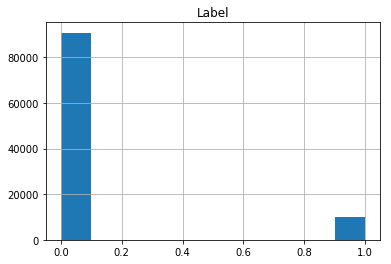

In [33]:
train.hist()

In [34]:
def Testing_grid_reg(X_train, Y_train, c=[10.0 ** i for i in range(-2, 3)]):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    pipe  = Pipeline([('cc', CountVectorizer(encoding = 'unicode')),
                     ('clf', SVC(class_weight = 'balanced', probability=True))])
    
    grid = {'clf__C' : c,
           'clf__kernel' : ['linear'],
           'clf__degree' : [1, 2],
           'clf__coef0' : [0.01, 0.4],
           'clf__probability': [True, False],
           'clf__shrinking' : [True, False],
           'clf__gamma' : [0.001, 0.1, 1],
           'cc__analyzer' : ['char'],
           'cc__min_df' : [3],
           'cc__max_df' : [14],
           'cc__ngram_range' : [(3, 8)]
           }
    
    start_time = datetime.datetime.now()
    gs = GridSearchCV(pipe, scoring='roc_auc', param_grid=grid, cv=cv, 
                      return_train_score=True, n_jobs=-1, verbose = True)
    
    gs.fit(X_train,Y_train)
    
    print ('Time elapsed:', datetime.datetime.now() - start_time)
    print (max(gs.cv_results_['mean_test_score']))
    
    return gs.best_params_

In [ ]:
p = Testing_grid_reg(train['Word'].as_matrix(), train['Label'].as_matrix())
print (p)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [ ]:
def vec(p):
    cc = CountVectorizer(encoding = 'unicode', 
                         analyzer = p['cc__analyzer'], 
                         ngram_range = p['cc__ngram_range'], 
                         min_df = p['cc__min_df'], 
                         max_df = p['cc__max_df'])
    
    X_train, y_train = cc.fit_transform(train['Word']), train['Label'].as_matrix()
    X_test = cc.transform(test['Word'])
    
    return X_train, y_train, X_test

def Predict(p):
    X_train, y_train, X_test = vec(p)
    
    clf = SVC(class_weight = 'balanced', 
              max_iter = p['clf__max_iter'], 
              n_jobs=-1,
              C = p['clf__C'],
              penalty = p['clf__penalty'])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    
    return y_pred

In [ ]:
y_pred = Predict(p)
sample = pd.read_csv('sample_submission.csv')
sample['Prediction'] = y_pred
sample.to_csv('res.csv',index=False)